In [ ]:
%matplotlib inline

### This code is based on PyTorch Tutorial examples and it is slightly modified or added
### @AI Robotics KR, Study-Pytorch


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




### More articles on transfer learning here
[A Gentle Introduction to Transfer Learning for Deep Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's take a look at datasets.<br>
***ImageFolder class***<br>
```
CLASS torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=<function default_loader>, is_valid_file=None)[SOURCE]
```
***A generic data loader where the images are arranged in this way:***
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```
<br>

***Params***<br>

```python
    root (string) – Root directory path.
    transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop
    target_transform (callable, optional) – A function/transform that takes in the target and transforms it.
    loader (callable, optional) – A function to load an image given its path
    is_valid_file – A function that takes path of an Image file and check if the file is a valid_file (used to check of corrupt files)
```

In [3]:
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train, 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: data/hymenoptera_data/val}


In [4]:
inputs, classes = next(iter(dataloaders['train']))
print(inputs.size(), inputs, classes)

torch.Size([4, 3, 224, 224]) tensor([[[[ 0.3309,  0.3309,  0.3994,  ..., -0.1999, -0.2171, -0.2342],
          [ 0.3481,  0.3481,  0.3994,  ..., -0.1999, -0.2171, -0.2342],
          [ 0.3309,  0.3481,  0.4166,  ..., -0.1999, -0.2342, -0.2342],
          ...,
          [ 0.1768,  0.3823,  0.5364,  ...,  1.3584,  1.3755,  1.3755],
          [ 0.1768,  0.3994,  0.5022,  ...,  1.3584,  1.3584,  1.3584],
          [ 0.1426,  0.3138,  0.3823,  ...,  1.3584,  1.3584,  1.3413]],

         [[ 1.2906,  1.3256,  1.3782,  ...,  0.9405,  0.9230,  0.8880],
          [ 1.3431,  1.3431,  1.4132,  ...,  0.9405,  0.9230,  0.9230],
          [ 1.3606,  1.3782,  1.4132,  ...,  0.9580,  0.9230,  0.9230],
          ...,
          [-0.7577, -0.5651, -0.4426,  ...,  1.8859,  1.9034,  1.9034],
          [-0.7927, -0.6001, -0.4776,  ...,  1.8859,  1.8859,  1.8859],
          [-0.7577, -0.6352, -0.5476,  ...,  1.8859,  1.9034,  1.9034]],

         [[-0.4798, -0.4798, -0.3927,  ..., -1.8044, -1.7870, -1.8044],
 

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



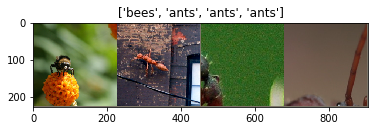

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    print('was_training=', was_training)
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




The models subpackage contains definitions of models for addressing different tasks, including:<br>
image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification. <br>

https://pytorch.org/docs/stable/torchvision/models.html

In [8]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
# Let's check model structure out
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




***If you encounter some problems w.r.t reading jpeg files, please update your pillow packages,
In my case, solve the problem by updating pillow version to 6.1.0 from 6.0.0***
<br>

pip install pillow --upgrade
Collecting pillow
  Downloading https://files.pythonhosted.org/packages/8f/f3/c6d351d7e582e4f2ef4343c9be1f0472cb249fb69695e68631e337f4b6e9/Pillow-6.1.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (3.8MB)
     |████████████████████████████████| 3.9MB 948kB/s 
Installing collected packages: pillow
  Found existing installation: Pillow 6.0.0
    Uninstalling Pillow-6.0.0:
      Successfully uninstalled Pillow-6.0.0
Successfully installed pillow-6.1.0


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5672 Acc: 0.6721
val Loss: 0.3528 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.6790 Acc: 0.7172
val Loss: 0.3422 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4984 Acc: 0.8033
val Loss: 0.2396 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5258 Acc: 0.7705
val Loss: 0.3745 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.7000 Acc: 0.7828
val Loss: 0.2925 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.8517 Acc: 0.7459
val Loss: 1.4480 Acc: 0.6928

Epoch 6/24
----------
train Loss: 0.4212 Acc: 0.8443
val Loss: 0.3427 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3160 Acc: 0.8770
val Loss: 0.2998 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3784 Acc: 0.8525
val Loss: 0.3376 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3083 Acc: 0.8770
val Loss: 0.3620 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.1973 Acc: 0.9180
val Loss: 0.2732 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2854 Acc: 0.8811
val Loss: 0.2504 Acc: 0.8954

Ep

was_training= False


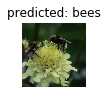

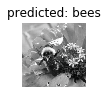

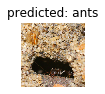

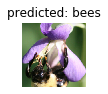

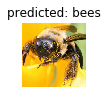

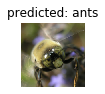

In [11]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7115 Acc: 0.5984
val Loss: 0.5564 Acc: 0.7516

Epoch 1/24
----------
train Loss: 0.4377 Acc: 0.7787
val Loss: 0.1523 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.5095 Acc: 0.7910
val Loss: 0.1708 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.7215 Acc: 0.7172
val Loss: 0.2893 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5546 Acc: 0.7910
val Loss: 0.2050 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3934 Acc: 0.8279
val Loss: 0.2786 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3535 Acc: 0.8484
val Loss: 0.1865 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3311 Acc: 0.8566
val Loss: 0.2143 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3914 Acc: 0.8238
val Loss: 0.2190 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4312 Acc: 0.8156
val Loss: 0.2270 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3106 Acc: 0.8689
val Loss: 0.1756 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3216 Acc: 0.8566
val Loss: 0.2204 Acc: 0.9346

Ep

was_training= False


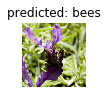

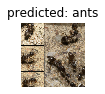

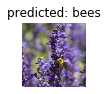

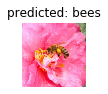

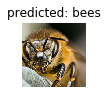

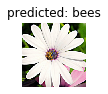

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()